# Updated Mask R-CNN - Train cell nucleus Dataset
This is an updated version of [Mask R-CNN - Train cell nucleus Dataset](https://colab.research.google.com/github/navidyou/Mask-RCNN-implementation-for-cell-nucleus-detection-executable-on-google-colab-/blob/master/mask_RCNN_cell_nucleus_google_colab.ipynb) for Google Colab. 

This notebook shows how to train Mask R-CNN implemented on coco on your own dataset. I trained the model to segment cell nucleus objects in an image. You'd need a GPU, because the network backbone is a Resnet101, which would be too slow to train on a CPU.The code is execuatble on google colaboratory GPU.  On google colab you can start to get okay-ish results in a few minutes, and good results in less than an hour.



## Initialisation


In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import os
    import sys
    import random
    import math
    import re
    import time
    import numpy as np
    import cv2
    import matplotlib
    import matplotlib.pyplot as plt
    import json
    #import pandas as pd
    from shlex import quote
    from time import time, ctime

    TOAST = True
    if TOAST:
        from win10toast import ToastNotifier
        toaster = ToastNotifier()

    from skimage.io import imread, imshow, imread_collection, concatenate_images
    from skimage.transform import resize

    # Data Path
    TRAIN_PATH = 'nephrology_dataset_train/'
    MAP_PATH = 'nephrology_dataset_val/'

    # Get train and test IDs
    train_ids = next(os.walk(TRAIN_PATH))[1]
    map_ids = next(os.walk(MAP_PATH))[1]


    IMAGE_FORMAT = 'png' #@param ['jp2', 'png', 'jpg', 'bmp']
    NB_STEPS = len(train_ids)
    
    NB_EPOCHS = 100
    
    init_with = "last" #@param ["coco", "imagenet", "last", "coco&cell"]
    NB_CLASS = 7
    COLOR_PER_CLASS = True
    evaluation_size = len(map_ids)
    # evaluation_size = 30 #@param {type:"slider", min:10, max:65, step:1}


    import config
    import utils
    import model
    import visualize

    from config import Config
    import utils
    import model as modellib
    import visualize
    from model import log

    %matplotlib inline 

    # Root directory of the project
    ROOT_DIR = os.getcwd()

    # Directory to save logs and trained model
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")

    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    # Download COCO trained weights from Releases if needed
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    print("Cell done")

Using TensorFlow backend.


Cell done


## Configurations

In [2]:
class CellsConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cells"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + NB_CLASS  # background + all classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = NB_STEPS

    # set validation steps
    VALIDATION_STEPS = 50


config = CellsConfig()
# config.display()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    #fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    #return ax
    return plt.subplots(rows, cols, figsize=(size*cols, size*rows), frameon=False)

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class CellsDataset(utils.Dataset):
    __CELLS_CLASS_NAMES = ["tubule_sain", "tubule_atrophique", "nsg_complet", "nsg_partiel", "pac", "vaisseau",
                         "artefact"]
    mode = ""

    def get_class_names(self):
        return self.__CELLS_CLASS_NAMES.copy()

    def load_cells(self, mode):
        # Add classes
        self.add_class("cells", 1, "tubule_sain")
        self.add_class("cells", 2, "tubule_atrophique")
        self.add_class("cells", 3, "nsg_complet")
        self.add_class("cells", 4, "nsg_partiel")
        self.add_class("cells", 5, "pac")
        self.add_class("cells", 6, "vaisseau")
        self.add_class("cells", 7, "artefact")

        self.mode = mode
        if self.mode == "train":
            for n, id_ in enumerate(train_ids):
                path = TRAIN_PATH + id_
                img_path = path + '/images/'
                self.add_image("cells", image_id=id_, path=img_path)

        if self.mode == "val":
            for n, id_ in enumerate(map_ids):
                path = MAP_PATH + id_
                img_path = path + '/images/'
                self.add_image("cells", image_id=id_, path=img_path)

    def load_image(self, image_id):

        info = self.image_info[image_id]
        info = info.get("id")

        if self.mode == "train":
            path = TRAIN_PATH + info
        else:
            path = MAP_PATH + info
        img = imread(path + '/images/' + info + '.' + IMAGE_FORMAT)[:, :, :3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

        return img

    def image_reference(self, image_id):
        """Return the cells data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cells":
            return info["cells"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for cells of the given image ID.
        """
        info = self.image_info[image_id]
        info = info.get("id")

        if self.mode == "train":
            path = TRAIN_PATH + info
        else:
            path = MAP_PATH + info

        # Counting masks for current image
        number_of_masks = 0
        for masks_dir in os.listdir(path):
            # For each directory excepting /images
            if masks_dir in ['images', 'full_images', 'cortex']:
                continue
            temp_DIR = path + '/' + masks_dir
            # Adding length of directory https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
            number_of_masks += len(
                [name for name in os.listdir(temp_DIR) if os.path.isfile(os.path.join(temp_DIR, name))])

        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        class_ids = np.zeros((number_of_masks,), dtype=int)
        for masks_dir in os.listdir(path):
            if masks_dir in ['images', 'full_images', 'cortex']:
                continue
            temp_class_id = self.__CELLS_CLASS_NAMES.index(masks_dir) + 1
            for mask_file in next(os.walk(path + '/' + masks_dir + '/'))[2]:
                mask_ = imread(path + '/' + masks_dir + '/' + mask_file)
                mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant',
                               preserve_range=True)
                mask[:, :, iterator] = mask_
                class_ids[iterator] = temp_class_id
                iterator += 1
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        return mask, class_ids.astype(np.int32)

In [5]:
'''dataset_test = CellsDataset()
dataset_test.load_cells('train')
dataset_test.prepare()
dataset_test.load_mask(0)'''

"dataset_test = CellsDataset()\ndataset_test.load_cells('train')\ndataset_test.prepare()\ndataset_test.load_mask(0)"

In [6]:
# Training dataset
dataset_train = CellsDataset()
dataset_train.load_cells("train")
dataset_train.prepare()

# Validation dataset
dataset_val = CellsDataset()
dataset_val.load_cells("val")
dataset_val.prepare()

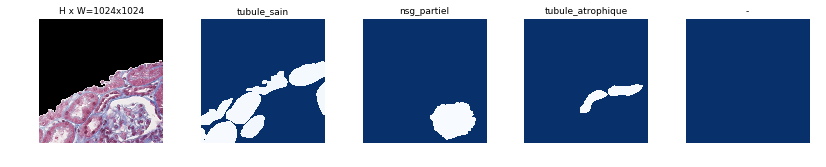

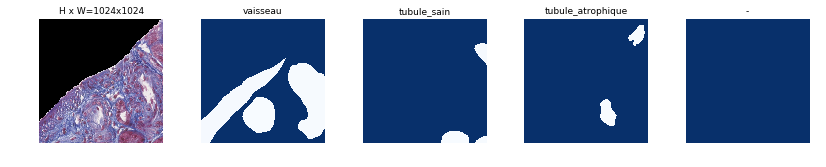

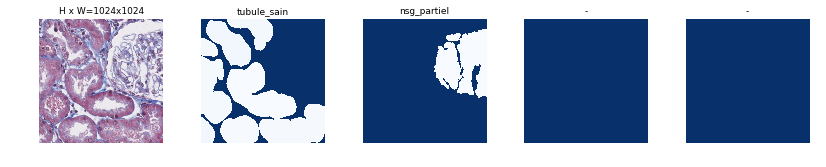

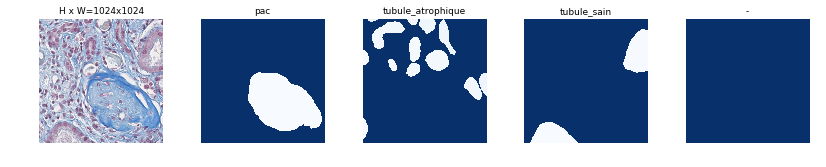

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?


if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    listDir = os.listdir(MODEL_DIR)
    listDir.sort()
    lastDir = ''
    for logDir in listDir:
        if os.path.isdir(os.path.join(MODEL_DIR, logDir)) and 'cells20' in logDir:
            lastDir = logDir
    lastDirPath = os.path.join(MODEL_DIR, lastDir)
    listDir = os.listdir(lastDirPath)
    listDir.sort()
    lastFile = ''
    for logFile in listDir:
        if '.h5' in logFile:
            lastFile = logFile
    if lastFile == '':
        print("Last file not found, using coco&cell")
        init_with = "coco&cell"
        weights_path = os.path.join(MODEL_DIR, 'mask_rcnn_shapes3.h5')
    else:
        weights_path = os.path.join(lastDirPath, lastFile)
        print("Last file is " + weights_path)
    model.load_weights(weights_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "coco&cell":
  weights_path = os.path.join(MODEL_DIR, 'mask_rcnn_shapes3.h5')
  model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", 
                                                          "mrcnn_mask"])

Last file is D:\Bureau\Training Test\logs\cells20200504T0910\mask_rcnn_cells_0052.h5
Re-starting from epoch 52


## Training

### Starting to train
Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
if TOAST:
    toaster.show_toast("Mask R-CNN",
                       "Starting training ({} steps, {} epochs)".format(NB_STEPS, NB_EPOCHS),
                       icon_path=None,
                       duration=10,
                       threaded=True)
start_time = time()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=NB_EPOCHS, 
            layers='heads')

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 52. LR=0.001

Checkpoint Path: D:\Bureau\Training Test\logs\cells20200504T0910\mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2   

c:\users\ajaug\anaconda3\envs\tensorflow1_7\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 53/100
451/451 [==============================] - 1057s 2s/step - loss: 1.2141 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.1734 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.2225 - val_loss: 1.1991 - val_rpn_class_loss: 0.0136 - val_rpn_bbox_loss: 0.6215 - val_mrcnn_class_loss: 0.1166 - val_mrcnn_bbox_loss: 0.2418 - val_mrcnn_mask_loss: 0.2056
Epoch 54/100
451/451 [==============================] - 1045s 2s/step - loss: 0.9537 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.1809 - val_loss: 1.1365 - val_rpn_class_loss: 0.0137 - val_rpn_bbox_loss: 0.5925 - val_mrcnn_class_loss: 0.1174 - val_mrcnn_bbox_loss: 0.2110 - val_mrcnn_mask_loss: 0.2019
Epoch 55/100
451/451 [==============================] - 1057s 2s/step - loss: 0.8895 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4495 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.1752 - val_loss: 1.1045 - val_rp

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
'''model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")'''

In [ ]:
training_time = round(time() - start_time)
if TOAST:
    h = ('0' if training_time // 3600 < 10 else '') + str(training_time // 3600)
    m = ('0' if (training_time % 3600) // 60 < 10 else '') + str((training_time % 3600) // 60)
    s = ('0' if training_time % 60 < 10 else '') + str(training_time % 60)
    toaster.show_toast("Mask R-CNN",
                       "Finish training ({} steps, {} epochs) in {}:{}:{}".format(NB_STEPS, NB_EPOCHS, h, m, s),
                       icon_path=None,
                       duration=10,
                       threaded=True)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
weights_saved_file = "mask_rcnn_nephrologie_{}_{}.h5".format(NB_STEPS, NB_EPOCHS)
model_path = os.path.join(MODEL_DIR, weights_saved_file)
model.keras_model.save_weights(model_path)

## Detection

### Initialisation of the inference model and loading of weights 

In [ ]:
class InferenceConfig(CellsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
if model_path is None or not os.path.exists(model_path):
  model_path = os.path.join(MODEL_DIR, weights_saved_file)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

### Inference on random selection

Display of randomly chosen image with exepected result

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config,
                                                                                   image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, 
                            colorPerClass=COLOR_PER_CLASS, figsize=(16, 16), 
                            title="{} Expected".format(map_ids[image_id]), 
                            fileName="logs/images/[{}_{}] Expected".format(NB_STEPS, NB_EPOCHS))

Detection and display of the predicted image

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
fig_, ax_ = get_ax(size=16)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, 
                            r['scores'], colorPerClass=COLOR_PER_CLASS, figsize=(16, 16), ax=ax_, fig=fig_, 
                            title="{} Predicted".format(map_ids[image_id]), 
                            fileName="logs/images/[{}_{}] Predicted".format(NB_STEPS, NB_EPOCHS))

## Evaluation

### Mean Average Precision (mAP) computation on a multiple-detection test 

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
#Running on 30 images by default. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, evaluation_size)
image_ids = dataset_val.image_ids
random.shuffle(image_ids)
APs = []
confusion_matrix = np.zeros((NB_CLASS + 1, NB_CLASS + 1), 
                            dtype=np.int32)
iterator = 1
map_time = time()
if TOAST:
    toaster.show_toast("Mask R-CNN",
                       "Starting mAP computation",
                       icon_path=None,
                       duration=10,
                       threaded=True)
for image_id in image_ids:
    if TOAST and iterator == evaluation_size // 2:
        toaster.show_toast("Mask R-CNN", "50% mAP computation achieved",
                           icon_path=None, duration=10, threaded=True)
    start_time = time()
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, 
                                                       inference_config),
                                   0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps, temp_confusion_matrix = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"],
                             r["class_ids"], r["scores"], r['masks'],
                             nb_class=NB_CLASS, 
                             confusion_iou_threshold=0.1)
    APs.append(AP)
    confusion_matrix = np.add(confusion_matrix, temp_confusion_matrix)
    duration = time() - start_time
    minu = int(duration / 60)
    sec = int(duration % 60)
    iterator += 1

map_time = round(time() - map_time)
mAP = np.mean(APs)
mAP_str = str(mAP).replace('.', ',')
print("mAP: ", mAP_str)
name = "[{}_{}] Confusion Matrix".format(NB_STEPS, NB_EPOCHS)
name2 = "[{}_{}] Normalized Confusion Matrix".format(NB_STEPS, NB_EPOCHS)
saveDir = 'logs/confusion_matrix/'
cmap = plt.cm.get_cmap('hot')
visualize.display_confusion_matrix(confusion_matrix, 
                                   dataset_val.get_class_names(), 
                                   title=name, cmap=cmap, show=False,
                                   fileName=saveDir + name)
visualize.display_confusion_matrix(confusion_matrix, 
                                   dataset_val.get_class_names(), 
                                   title=name2, cmap=cmap, show=False, 
                                   normalize=True, 
                                   fileName=saveDir + name2)
with open("logs/auto_results.csv", "a") as file:
    file.write('"{}"; "{}"; "{}"; {}; {}; {}; {}\n'.format(ctime(time()),
                                                           init_with,
                                                           weights_saved_file,
                                                           NB_STEPS,
                                                           NB_EPOCHS,
                                                           training_time,
                                                           mAP_str))

In [ ]:
if TOAST:
    m = ('0' if map_time // 60 < 10 else '') + str(map_time // 60)
    s = ('0' if map_time % 60 < 10 else '') + str(map_time % 60)
    toaster.show_toast("Mask R-CNN",
                       "mAP computed : {:.3f}%\nDuration : {}:{}".format(mAP*100, m, s),
                       icon_path=None,
                       duration=30,
                       threaded=True)